# MTP - Network Analytics

## Import and Installation

In [1]:
# Remove any annotations if required to install a package
# pip install cpnet
# pip install collections
# pip install powerlaw
# pip install operator

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx.algorithms.community as nxcom
from networkx.algorithms import eigenvector_centrality
import collections
import powerlaw
import operator
import cpnet

In [3]:
# Reading the dataset and adding it to a pandas dataframe
# Column headers were added to the dataset csv file to to aid data cleaning
net_data = pd.read_csv('soc-sign-bitcoinalpha1.csv', encoding='utf-8')

## Data Cleaning

In [4]:
# Converting epoch to an understandable date-time format
net_data['time1'] = pd.to_datetime(net_data['time'], unit='s')

# Creating a new column - 'year' of interaction
net_data['year'] = net_data['time1'].dt.year

In [5]:
# Setting 'year' as index and sorting the data
net_data.set_index('year', inplace=True)
net_data.sort_index()

# Dropping the 3 years where the data is not needed
net_data.drop([2010, 2011, 2012], inplace=True)

# Dropping the unnecessary time columns
net_data.drop(columns=['time', 'time1'], axis=1, inplace=True)

# Data count check
net_data.index.value_counts()

2013    6121
2014    2735
2015     362
2016      17
Name: year, dtype: int64

In [6]:
# Visualising the dataframe
net_data

,source,target,rating
year,,,
2014,7188,1,10
2013,430,1,10
2013,3134,1,10
2014,160,1,10
2013,95,1,9
...,...,...,...
2013,7604,7601,10
2013,7601,7604,10
2013,7604,7602,10


## Creating a Weighted Directed Network Graph

In [7]:
# Reading the dataframe "net_data" as a Directed Graph
G = nx.from_pandas_edgelist(net_data, source='source', target='target', edge_attr='rating', create_using=nx.DiGraph())

# Checking the data to see if nodes and edges are imported properly
G?

## Descriptive Statistics

In [8]:
# Calculating the density of the network
ds = nx.density(G)
print(f"The Network has a density of", ds)

The Network has a density of 0.002939438963433188


In [9]:
# Getting statistics on degree distribution
dv = dict(G.degree())
dd = list(dv.values())
print("""
==============================================
    Summary stats on degree distribution
==============================================
Mu    :       {:.3f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.3f}
""".format(np.mean(dd), np.min(dd), np.max(dd), np.std(dd)))


    Summary stats on degree distribution
Mu    :       10.417
Min   :           1
Max   :         399
Sigma :       26.118



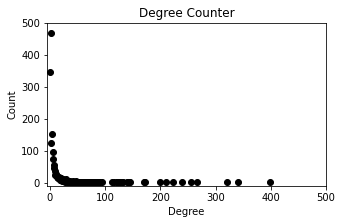

In [10]:
ds = collections.Counter(dd)
fig1 = plt.figure(figsize=(5, 3))
plt.style.use('default')
fig1.patch.set_facecolor('white')

ax0 = fig1.add_subplot(1, 1, 1)
ax0.scatter(ds.keys(), ds.values(), color='k')
ax0.set_title('Degree Counter')
ax0.set_xlabel('Degree')
ax0.set_ylabel('Count')
plt.xlim([-5, 500])
plt.ylim([-10, 500])
plt.show()

In [11]:
# node degree
node_degree = G.degree()

# data series to plot
e = [d for n, d in node_degree]

# fit powerlaw
fit = powerlaw.Fit(e)
alpha = fit.power_law.alpha
sigma = fit.power_law.sigma
cmp = fit.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


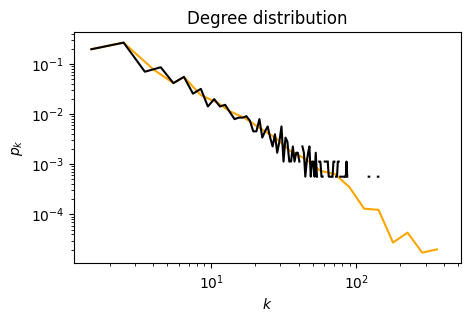

In [12]:
# create figure
fig1 = plt.figure(figsize=(5, 3))
plt.rcParams.update(plt.rcParamsDefault)
fig1.patch.set_facecolor('white')

# add plot
ax1 = fig1.add_subplot(1, 1, 1)

# plot data
powerlaw.plot_pdf(e, color='orange', ax=ax1)
powerlaw.plot_pdf(e, linear_bins=True, color='black', ax=ax1)

# title
ax1.set_title("Degree distribution")

# labels
ax1.set_ylabel(r"$p_{k}$")
ax1.set_xlabel(r"$k$")

# show plot
plt.show()

## Visualisation

In [13]:
# Count the number of communities
comms = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The Exchange has {len(comms)} communities.")

The Exchange has 38 communities.


In [14]:
def assign_nodes_coms(G, comms):
# Adding the community to node attributes
        for a, v_a in enumerate(comms):
            for b in v_a:
                # Add 1 to save 0 for external edges
                G.nodes[b]['community'] = a + 1
            

In [15]:
def assign_edge_coms(G):
# Finding internal edges and adding their community to their attributes
        for b, c, in G.edges:
            if G.nodes[b]['community'] == G.nodes[c]['community']:
                # Internal edge, mark with community
                G.edges[b, c]['community'] = G.nodes[b]['community']
            else:
                # External edge, mark as 0
                G.edges[b, c]['community'] = 0

In [16]:
def assign_colour(i, orig_r=1, orig_g=1, orig_b=1):
# Assigning a colour to a vertex.
        r0, g0, b0 = 0, 0, 0
        n = 20
        low, high = 0.1, 0.95
        span = high - low
        r = low + span * (((i + orig_r) * 3) % n) / (n - 1)
        g = low + span * (((i + orig_g) * 5) % n) / (n - 1)
        b = low + span * (((i + orig_b) * 7) % n) / (n - 1)
        return (r, g, b)

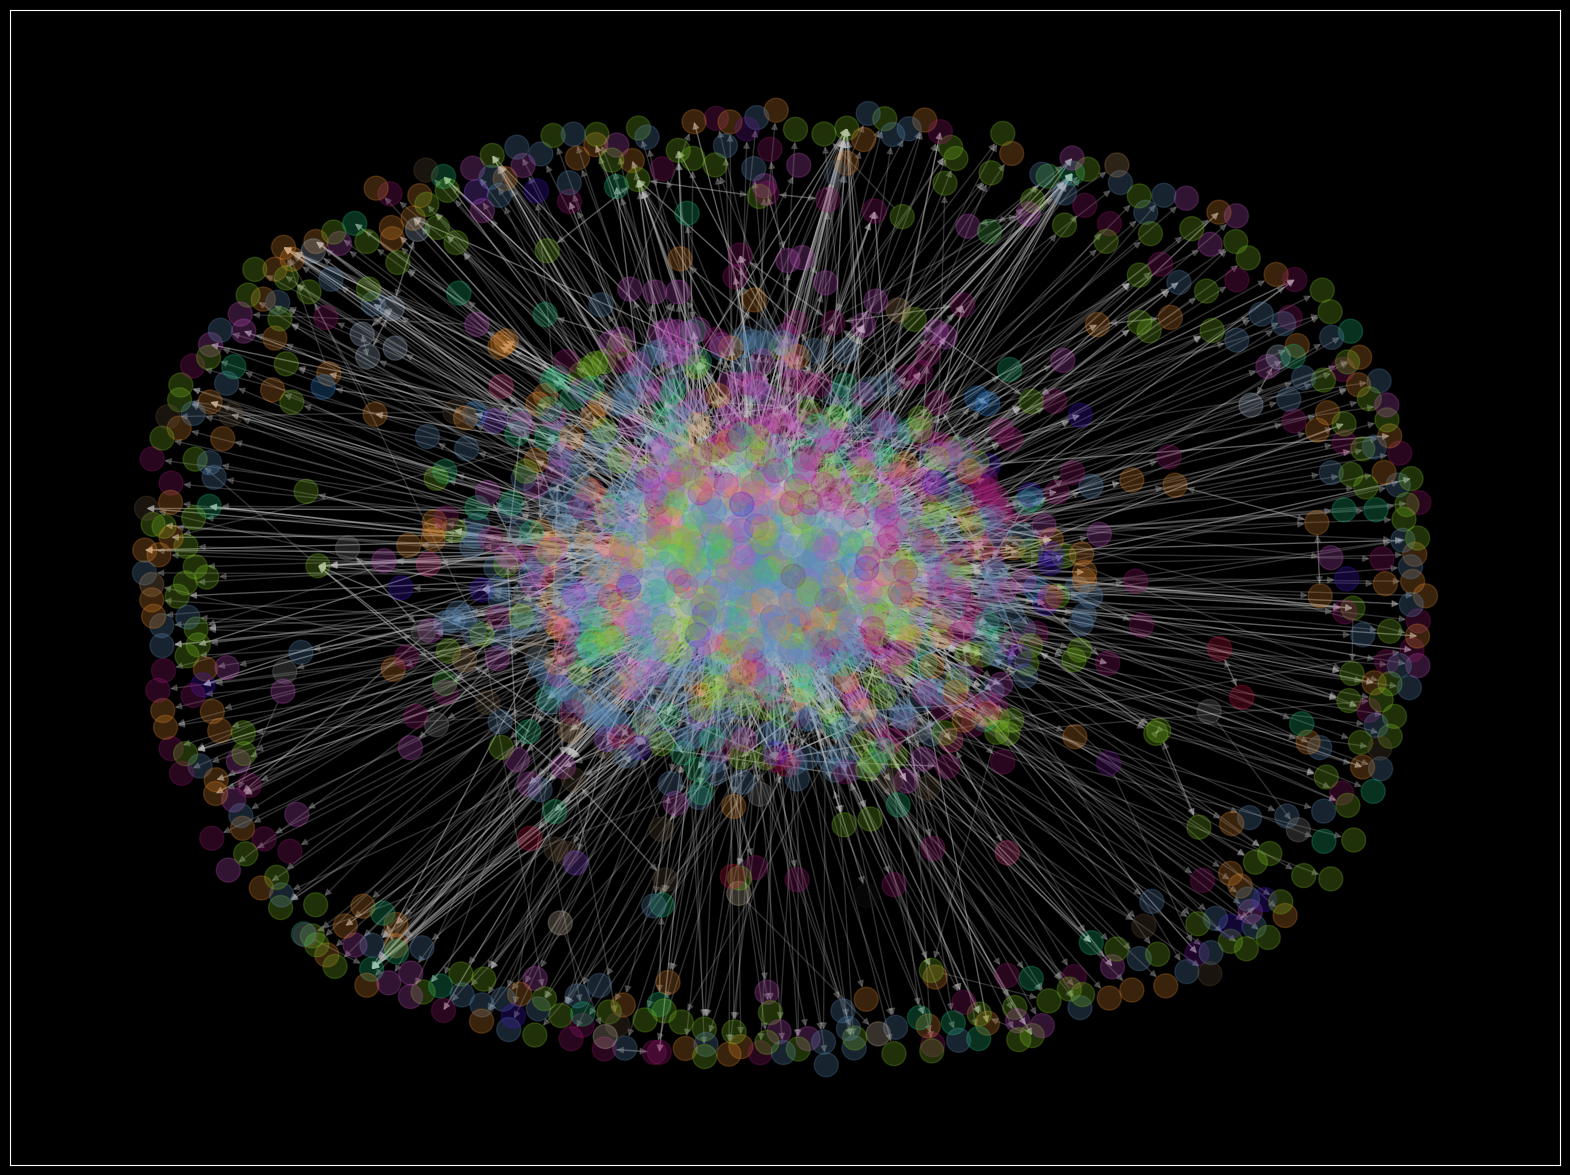

In [17]:
position1 = nx.spring_layout(G, k=0.1)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (20, 15)})
plt.style.use('dark_background')

# Set node and edge communities
assign_nodes_coms(G, comms)
assign_edge_coms(G)

# Set colour for internal edges
external = [(b, c) for b, c in G.edges if G.edges[b, c]['community'] == 0]
internal = [(b, c) for b, c in G.edges if G.edges[b, c]['community'] > 0]
internal_colour = ["silver" for e in internal]
node_colour = [assign_colour(G.nodes[b]['community']) for b in G.nodes]

# external edges
nx.draw_networkx(
    G, 
    pos=position1, 
    node_size=0, 
    edgelist=external, 
    edge_color="silver",
    node_color=node_colour,
    alpha=0.5, 
    with_labels=False)

# internal edges
nx.draw_networkx(
    G, pos=position1, 
    edgelist=internal, 
    edge_color=internal_colour,
    node_color=node_colour,
    alpha=0.25, 
    with_labels=False)
plt.show()

## Centrality metrics

In [18]:
# Calculating the different centrality metrics
dc = nx.degree_centrality(G)
ec = nx.eigenvector_centrality(G)
bc = nx.betweenness_centrality(G)
cc = nx.closeness_centrality(G)

In [19]:
#List of top eigenvector centrality nodes
sorted_eigenvector = sorted(ec.items(), key=operator.itemgetter(1), reverse=True)
print("Top 20 nodes by eigenvector centrality:")
for f in sorted_eigenvector[:20]:
    print(f)

Top 20 nodes by eigenvector centrality:
(3, 0.24588048520547284)
(5, 0.23299617750311377)
(19, 0.20901962462833648)
(12, 0.20679385879937165)
(11, 0.16188964832493466)
(6, 0.15727240224018751)
(36, 0.1528726236467005)
(34, 0.14762097984846936)
(27, 0.14672222214164946)
(125, 0.13849670540878278)
(49, 0.13276187141310844)
(95, 0.13180453936237196)
(26, 0.12653728136856923)
(7, 0.12592861324149898)
(177, 0.12374519603826777)
(32, 0.11681691380922232)
(58, 0.11419392212105109)
(29, 0.11105566868764599)
(85, 0.11077950117032906)
(31, 0.1078022678665863)


## Modularity

In [20]:
# Loading the Borgatti-Everett algorithm
algo = cpnet.BE()
algo.detect(G)

h = algo.get_coreness() # Get the coreness of nodes
j = algo.get_pair_id()  # Get the group membership of nodes

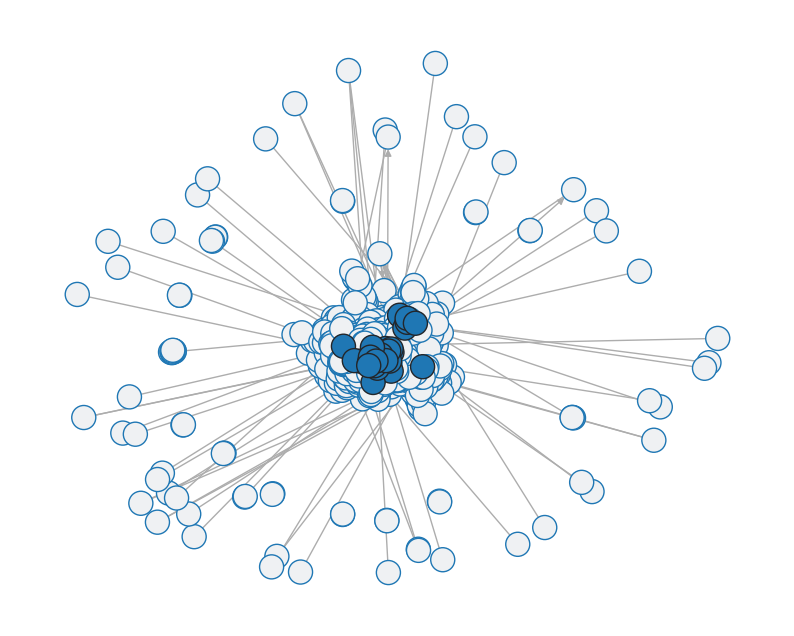

In [21]:
# Visualising the Core-Periphery structure using the Borgatti-Everett algorithm
fig2 = plt.figure(figsize=(10,8))
plt.rcParams.update(plt.rcParamsDefault)
fig2.patch.set_facecolor('white')

ax2 = plt.gca()
ax2, pos = cpnet.draw(G, j, h, ax2)
plt.show()

In [22]:
# Loading the KM algorithm
kmconfig = cpnet.KM_config()
kmconfig.detect(G)

j1 = kmconfig.get_pair_id()
h1 = kmconfig.get_coreness()

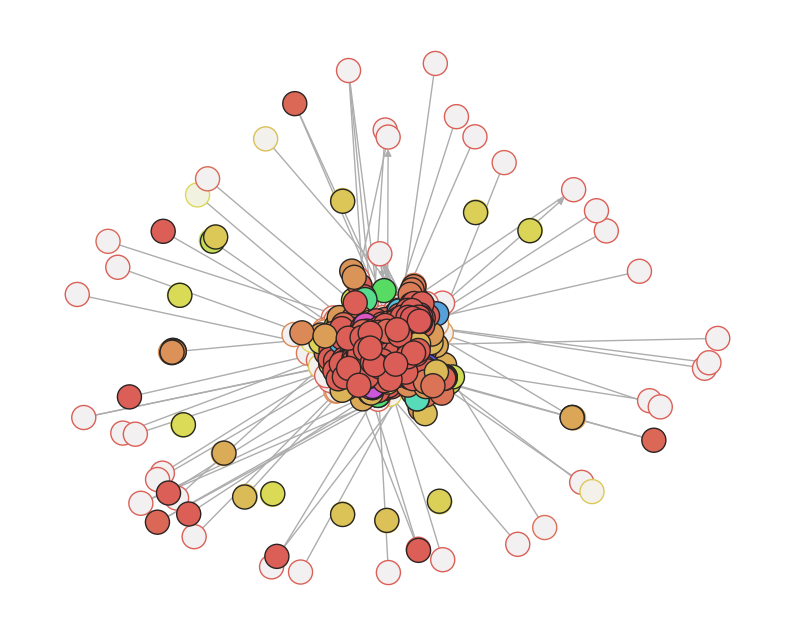

In [23]:
# Visualising multiple Core-Periphery pairs
fig2 = plt.figure(figsize=(10,8))
plt.rcParams.update(plt.rcParamsDefault)
fig2.patch.set_facecolor('white')

ax3 = plt.gca()
ax3, _ = cpnet.draw(G, j1, h1, ax3, pos=pos)
plt.show()

# Final Visualisation

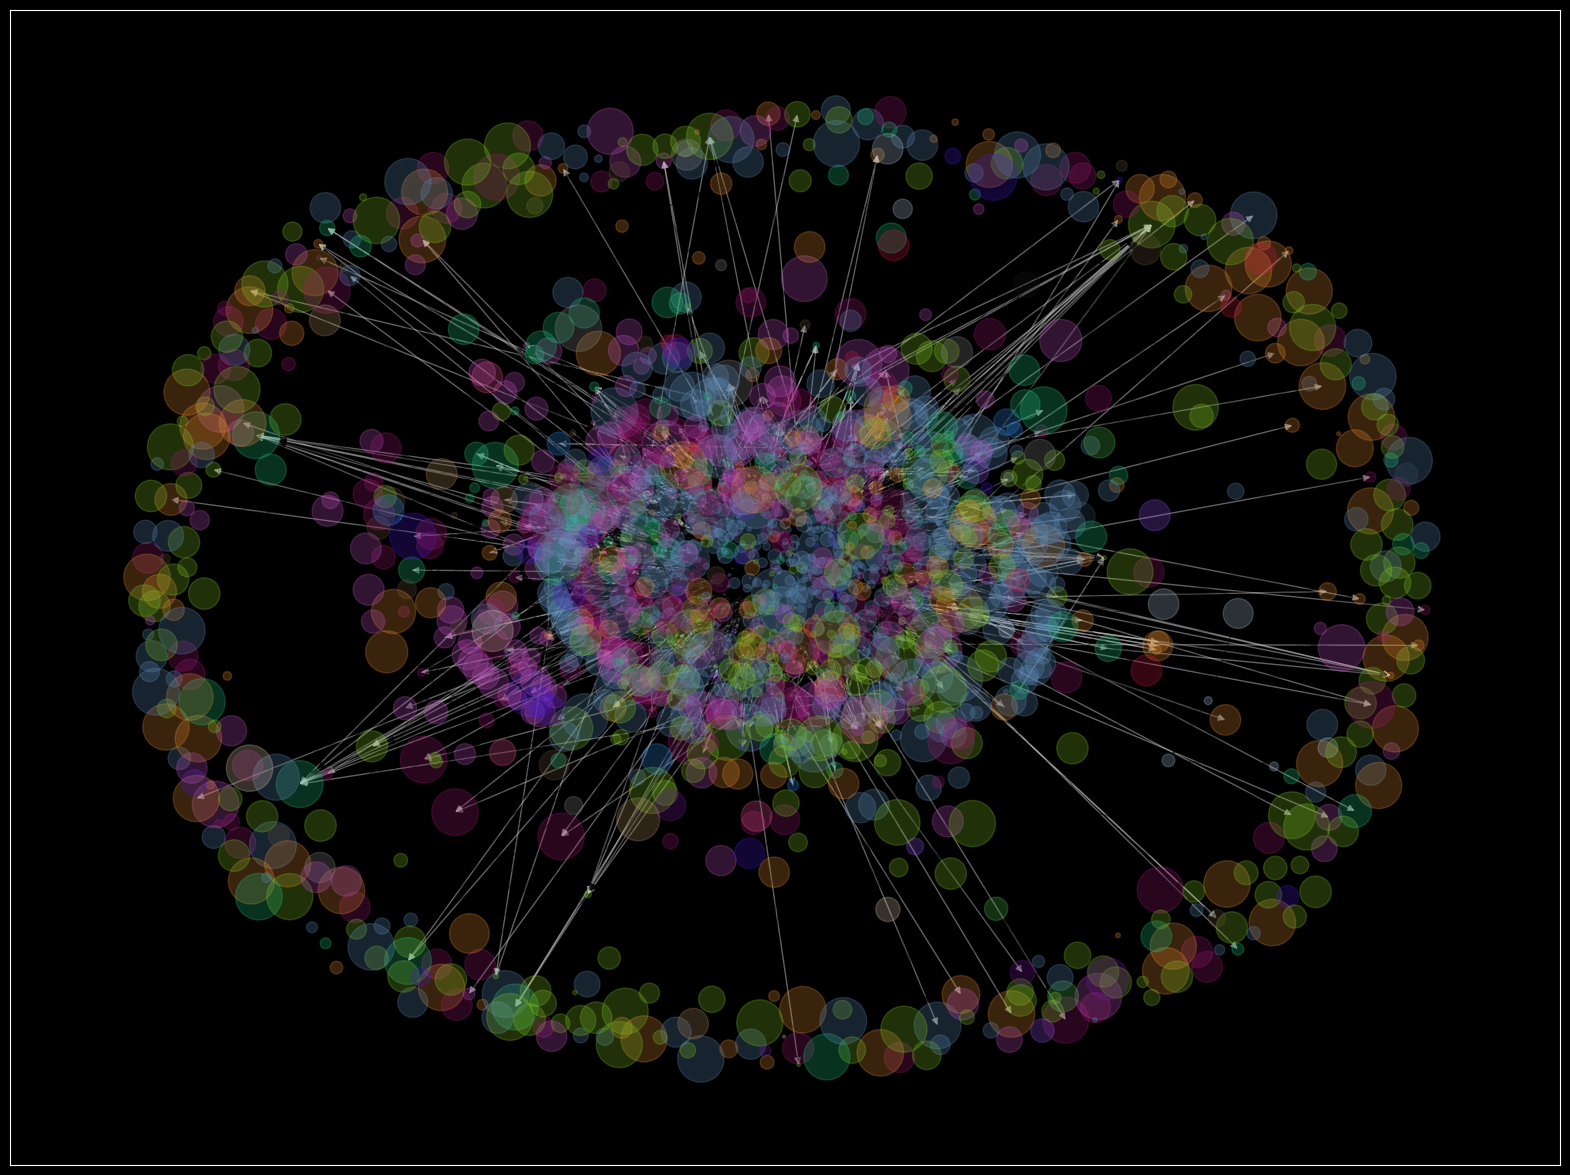

In [24]:
# Final graph where the node size is proportional to eigenvector centrality, and internal edges are hidden

position2 = nx.spring_layout(G, k=0.1)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (20, 15)})
plt.style.use('dark_background')

# Set node and edge communities
assign_nodes_coms(G, comms)
assign_edge_coms(G)

# Set community colour for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_colour = ["black" for e in internal] # Used black for the purpose of showing comms as opposed to individual nodes
node_colour = [assign_colour(G.nodes[v]['community']) for v in G.nodes]

# external edges
nx.draw_networkx(
    G, 
    pos=position2, 
    node_size=0, 
    edgelist=external, 
    edge_color="silver",
    node_color=node_colour,
    alpha=0.5, 
    with_labels=False)

# internal edges
nx.draw_networkx(
    G, pos=position2, 
    edgelist=internal, 
    edge_color=internal_colour,
    node_color=node_colour,
    node_size=[g*0.15 for g in ec],
    alpha=0.25, 
    with_labels=False)
plt.show()